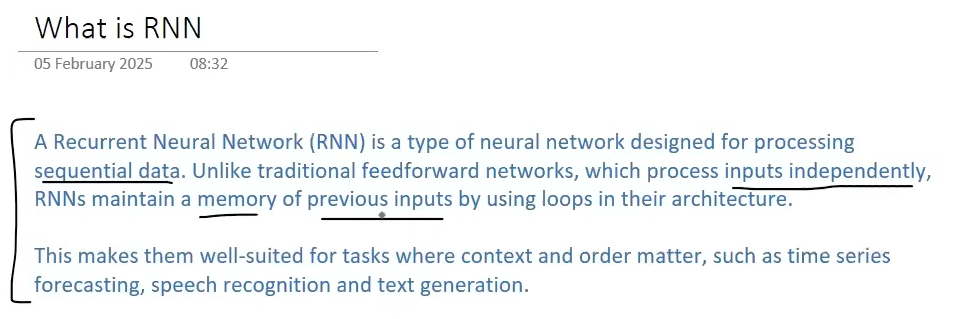

In [2]:
import pandas as pd

df = pd.read_csv('100_Unique_QA_Dataset.csv')
df.head()

,question,answer
0,What is the capital of France?,Paris
1,What is the capital of Germany?,Berlin
2,Who wrote 'To Kill a Mockingbird'?,Harper-Lee
3,What is the largest planet in our solar system?,Jupiter
4,What is the boiling point of water in Celsius?,100


In [3]:
# tokenise
def tokenize(text):
  text = text.lower()
  text = text.replace('?', '')
  text = text.replace("'", "")
  return text.split()

In [4]:
# voabulary
vocab = {'<UNK>': 0}

In [5]:
# convert word into numerical indices
def build_vocab(row):
  tokenized_question = tokenize(row['question'])
  tokenized_answer = tokenize(row['answer'])

  merged_tokens = tokenized_question + tokenized_answer

  for token in merged_tokens:

    if token not in vocab:
      vocab[token] = len(vocab)

  # print(merged_tokens)


In [6]:
df.apply(build_vocab, axis=1)

,0
0,None
1,None
2,None
3,None
4,None
...,...
85,None
86,None
87,None
88,None


In [7]:
len(vocab)

324

In [8]:
def text_to_indices(text, vocab):

  indexed_text = []

  for token in tokenize(text):

    if token in vocab:
      indexed_text.append(vocab[token])
    else:
      indexed_text.append(vocab['<UNK>'])

  return indexed_text

In [9]:
vocab

{'<UNK>': 0,
 'what': 1,
 'is': 2,
 'the': 3,
 'capital': 4,
 'of': 5,
 'france': 6,
 'paris': 7,
 'germany': 8,
 'berlin': 9,
 'who': 10,
 'wrote': 11,
 'to': 12,
 'kill': 13,
 'a': 14,
 'mockingbird': 15,
 'harper-lee': 16,
 'largest': 17,
 'planet': 18,
 'in': 19,
 'our': 20,
 'solar': 21,
 'system': 22,
 'jupiter': 23,
 'boiling': 24,
 'point': 25,
 'water': 26,
 'celsius': 27,
 '100': 28,
 'painted': 29,
 'mona': 30,
 'lisa': 31,
 'leonardo-da-vinci': 32,
 'square': 33,
 'root': 34,
 '64': 35,
 '8': 36,
 'chemical': 37,
 'symbol': 38,
 'for': 39,
 'gold': 40,
 'au': 41,
 'which': 42,
 'year': 43,
 'did': 44,
 'world': 45,
 'war': 46,
 'ii': 47,
 'end': 48,
 '1945': 49,
 'longest': 50,
 'river': 51,
 'nile': 52,
 'japan': 53,
 'tokyo': 54,
 'developed': 55,
 'theory': 56,
 'relativity': 57,
 'albert-einstein': 58,
 'freezing': 59,
 'fahrenheit': 60,
 '32': 61,
 'known': 62,
 'as': 63,
 'red': 64,
 'mars': 65,
 'author': 66,
 '1984': 67,
 'george-orwell': 68,
 'currency': 69,
 'unit

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

In [11]:
class QADataset(Dataset):

  def __init__(self, df, vocab):
    self.df = df
    self.vocab = vocab

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    numerical_question = text_to_indices(self.df.iloc[index]['question'], self.vocab)
    numerical_answer = text_to_indices(self.df.iloc[index]['answer'], self.vocab)

    return torch.tensor(numerical_question), torch.tensor(numerical_answer)

In [12]:
dataset = QADataset(df, vocab)

In [13]:
dataset[0]

(tensor([1, 2, 3, 4, 5, 6]), tensor([7]))

In [14]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [15]:
# for question, answer in dataloader:
#   print(question, answer)

In [16]:
import torch.nn as nn
import torch.optim as optim

In [33]:
class SimpleRNN(nn.Module):
  def __init__(self, vocab_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim=50)
    self.rnn = nn.RNN(
        50,
        64,
        batch_first=True
    )
    self.fc = nn.Linear(64, vocab_size)

  def forward(self, question):
    embedded_question = self.embedding(question)
    hidden, final = self.rnn(embedded_question)
    return self.fc(final.squeeze(0))


In [34]:
learning_rate = 0.001
epochs = 20

In [35]:
model = SimpleRNN(len(vocab))

In [36]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
for epoch in range(epochs):

  total_loss = 0

  for question, answer in dataloader:

    optimizer.zero_grad()

    output = model(question)

    # print(output.shape)
    # print(answer.shape)

    loss = criterion(output, answer[0])

    loss.backward()

    optimizer.step()

    total_loss += loss.item()

  print(f'Epoch: {epoch}, Loss: {total_loss}')

Epoch: 0, Loss: 9.786975547671318
Epoch: 1, Loss: 8.534236788749695
Epoch: 2, Loss: 7.519841033965349
Epoch: 3, Loss: 6.735366467386484
Epoch: 4, Loss: 5.986178170889616
Epoch: 5, Loss: 5.418020978569984
Epoch: 6, Loss: 4.904295437037945
Epoch: 7, Loss: 4.446071159094572
Epoch: 8, Loss: 4.058291653171182
Epoch: 9, Loss: 3.7036569118499756
Epoch: 10, Loss: 3.4045812729746103
Epoch: 11, Loss: 3.130436170846224
Epoch: 12, Loss: 2.8861748669296503
Epoch: 13, Loss: 2.6731786597520113
Epoch: 14, Loss: 2.469765331596136
Epoch: 15, Loss: 2.2960802763700485
Epoch: 16, Loss: 2.1382246585562825
Epoch: 17, Loss: 1.9957311553880572
Epoch: 18, Loss: 1.8573723416775465
Epoch: 19, Loss: 1.7371814362704754


In [41]:
def predict(model, question, threshold=0.5):

  # question to number
  numerical_question = text_to_indices(question, vocab)

  question_tensor = torch.tensor(numerical_question).unsqueeze(0)

  output = model(question_tensor)

  prob = torch.nn.functional.softmax(output, dim=1)

  # find index pf max prob
  value, index = torch.max(prob, dim=1)

  if value < threshold:
    print("I dont know")
  else:
    print(list(vocab.keys())[index])


In [42]:
predict(model, 'what is the capital of france')

paris
